In [2]:
!pip install torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 MB 21.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 23.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12


In [4]:
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.1 MB/s eta 0:00:00a 0:00:01


Execution done Using MPS (Apple Silicon GPU)


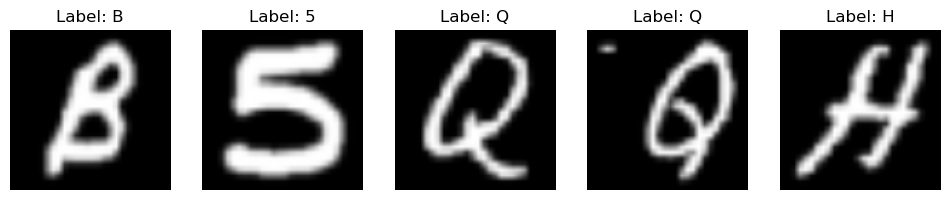

Total number of classes: 36
Total number of samples: 100800
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [1]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import time
from tqdm import tqdm

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Execution done using CUDA (NVIDIA GPU)")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Execution done Using MPS (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    print("Execution done Using CPU")

transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.Resize((128, 128)),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  
])

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


#given dataset
data_path = 'cnn_dataset'  
dataset = datasets.ImageFolder(root=data_path, transform=transform_train)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size


train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


def show_samples(dataloader):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(1, 5, figsize=(12, 4))
    for i in range(5):
        ax = axes[i]
        ax.imshow(images[i].permute(1, 2, 0).squeeze(), cmap='gray')
        ax.set_title(f"Label: {dataset.classes[labels[i]]}")
        ax.axis('off')
    plt.show()

show_samples(train_loader)


print("Total number of classes:", len(dataset.classes))
print("Total number of samples:", len(dataset))
print("Classes:", dataset.classes)

In [2]:
#  VGG-13 architecture 
class VGG13(nn.Module):
    def __init__(self, num_classes=36):
        super(VGG13, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096), nn.ReLU(True), nn.Dropout(),
            nn.Linear(4096, 4096), nn.ReLU(True), nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Instantiate our VGG model
model_vgg = VGG13(num_classes=36).to(device)


In [3]:
# weights 
def initialize_weights(model):
    for i in model.modules():
        if isinstance(i, nn.Conv2d):
            nn.init.kaiming_normal_(i.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(i, nn.Linear):
            nn.init.normal_(i.weight, 0, 0.01)
            nn.init.constant_(i.bias, 0)


model_vgg.apply(initialize_weights)


VGG13(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16)

In [4]:
import time
from tqdm import tqdm
import torch.optim as optim

# Loss  , optimizer
criterion_vgg = nn.CrossEntropyLoss()
optimizer_vgg= optim.SGD(model_vgg.parameters(), lr=0.001,momentum=0.9,weight_decay=5e-4)

# Learning Rate Scheduler 
scheduler_vgg = optim.lr_scheduler.StepLR(optimizer_vgg, step_size=3, gamma=0.1)

def train_model_vgg(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10):
   
    train_losses_vgg = []
    val_losses_vgg = []
    train_accuracies_vgg = []
    val_accuracies_vgg = []
    total_training_time=0
    for epoch in range(epochs):
        epoch_start_time = time.time() 
        model.train()  
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = (correct / total)*100
        train_losses_vgg.append(train_loss)
        train_accuracies_vgg.append(train_accuracy)

        val_loss, val_accuracy = validate_model(model, val_loader, criterion)
        val_losses_vgg.append(val_loss)
        val_accuracies_vgg.append(val_accuracy)

        epoch_end_time = time.time()  
        epoch_duration = epoch_end_time - epoch_start_time  
        total_training_time += epoch_duration

        scheduler.step()

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, "
              f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}")
    print(f"Total training time: {total_training_time:.2f} seconds")
    return train_losses_vgg,train_accuracies_vgg,val_losses_vgg,val_accuracies_vgg
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = (correct / total)*100
    return avg_val_loss, val_accuracy

# Train  model using Learning Rate Scheduler
train_losses_vgg,train_accuracies_vgg,valid_losses_vgg,valid_accuracies_vgg=train_model_vgg(model_vgg, train_loader, val_loader, criterion_vgg, optimizer_vgg, scheduler_vgg, epochs=10)


Epoch 1/10: 100%|███████████████████████████| 1260/1260 [18:12<00:00,  1.15it/s]


Epoch [1/10], Train Loss: 1.9629, Train Accuracy: 44.4358, Validation Loss: 0.4743, Validation Accuracy: 83.5913, Learning Rate: 0.001000


Epoch 2/10: 100%|███████████████████████████| 1260/1260 [18:23<00:00,  1.14it/s]


Epoch [2/10], Train Loss: 0.4292, Train Accuracy: 85.0570, Validation Loss: 0.3141, Validation Accuracy: 88.8690, Learning Rate: 0.001000


Epoch 3/10: 100%|███████████████████████████| 1260/1260 [18:47<00:00,  1.12it/s]


Epoch [3/10], Train Loss: 0.3269, Train Accuracy: 88.0915, Validation Loss: 0.2608, Validation Accuracy: 90.3274, Learning Rate: 0.000100


Epoch 4/10: 100%|███████████████████████████| 1260/1260 [18:10<00:00,  1.16it/s]


Epoch [4/10], Train Loss: 0.2596, Train Accuracy: 90.2840, Validation Loss: 0.2367, Validation Accuracy: 91.2401, Learning Rate: 0.000100


Epoch 5/10: 100%|█████████████████████████| 1260/1260 [2:46:15<00:00,  7.92s/it]


Epoch [5/10], Train Loss: 0.2433, Train Accuracy: 90.8978, Validation Loss: 0.2319, Validation Accuracy: 91.4683, Learning Rate: 0.000100


Epoch 6/10: 100%|███████████████████████████| 1260/1260 [24:37<00:00,  1.17s/it]


Epoch [6/10], Train Loss: 0.2345, Train Accuracy: 91.1099, Validation Loss: 0.2308, Validation Accuracy: 91.4782, Learning Rate: 0.000010


Epoch 7/10: 100%|███████████████████████████| 1260/1260 [19:02<00:00,  1.10it/s]


Epoch [7/10], Train Loss: 0.2272, Train Accuracy: 91.3628, Validation Loss: 0.2284, Validation Accuracy: 91.6071, Learning Rate: 0.000010


Epoch 8/10: 100%|███████████████████████████| 1260/1260 [18:33<00:00,  1.13it/s]


Epoch [8/10], Train Loss: 0.2261, Train Accuracy: 91.4211, Validation Loss: 0.2279, Validation Accuracy: 91.6667, Learning Rate: 0.000010


Epoch 9/10: 100%|███████████████████████████| 1260/1260 [18:24<00:00,  1.14it/s]


Epoch [9/10], Train Loss: 0.2250, Train Accuracy: 91.3331, Validation Loss: 0.2273, Validation Accuracy: 91.6766, Learning Rate: 0.000001


Epoch 10/10: 100%|██████████████████████████| 1260/1260 [18:27<00:00,  1.14it/s]


Epoch [10/10], Train Loss: 0.2226, Train Accuracy: 91.4149, Validation Loss: 0.2273, Validation Accuracy: 91.6468, Learning Rate: 0.000001
Total training time: 20701.30 seconds


In [23]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
all_predictions = []
all_labels = []
def evaluate_vgg(model, test_loader):
    model.eval()
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)*100
    print(f"Test Accuracy: {accuracy :.2f}%")

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='macro')
    print(f"Precision: {precision*100:.4f}")
    print(f"Recall: {recall*100:.4f}")
    print(f"F1 Score: {f1*100:.4f}")

    return all_labels,all_predictions,accuracy, precision, recall, f1

# Evaluate using test set
all_labels_vgg,all_prdictions_vgg,test_accuracy_vgg, test_precision_vgg, test_recall_vgg, test_f1_score_vgg = evaluate_vgg(model_vgg, test_loader)


Test Accuracy: 91.49%
Precision: 91.6281
Recall: 91.5213
F1 Score: 91.4583


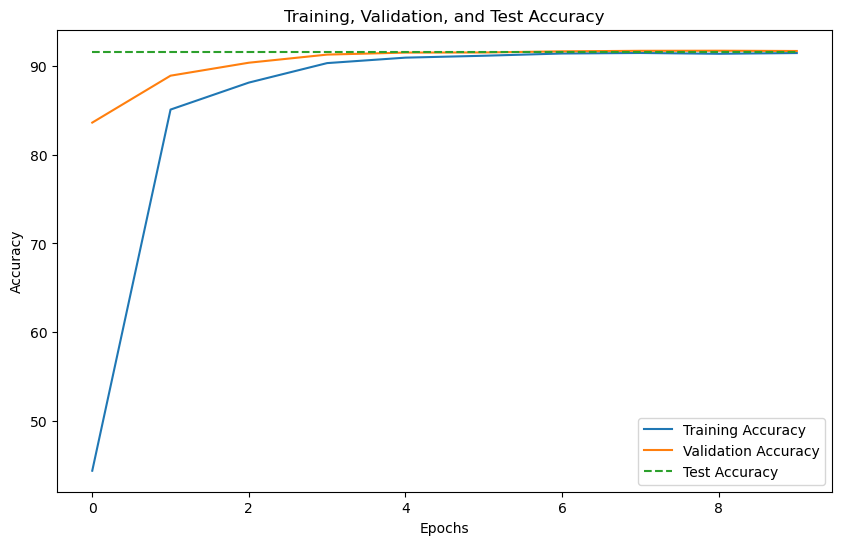

In [24]:

test_accuracies_vgg = [test_accuracy_vgg] * len(train_accuracies_vgg)

plt.figure(figsize=(10, 6))
plt.plot(train_accuracies_vgg, label='Training Accuracy')
plt.plot(valid_accuracies_vgg, label='Validation Accuracy')
plt.plot(test_accuracies_vgg, label='Test Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.show()


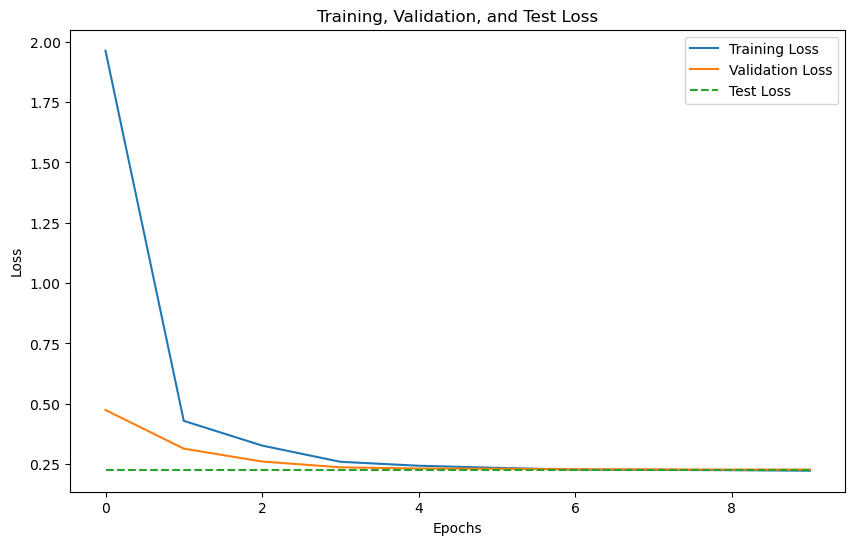

In [25]:

test_losses_vgg = [valid_losses_vgg[-1]] * len(train_losses_vgg)

plt.figure(figsize=(10, 6))
plt.plot(train_losses_vgg, label='Training Loss')
plt.plot(valid_losses_vgg, label='Validation Loss')
plt.plot(test_losses_vgg, label='Test Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()


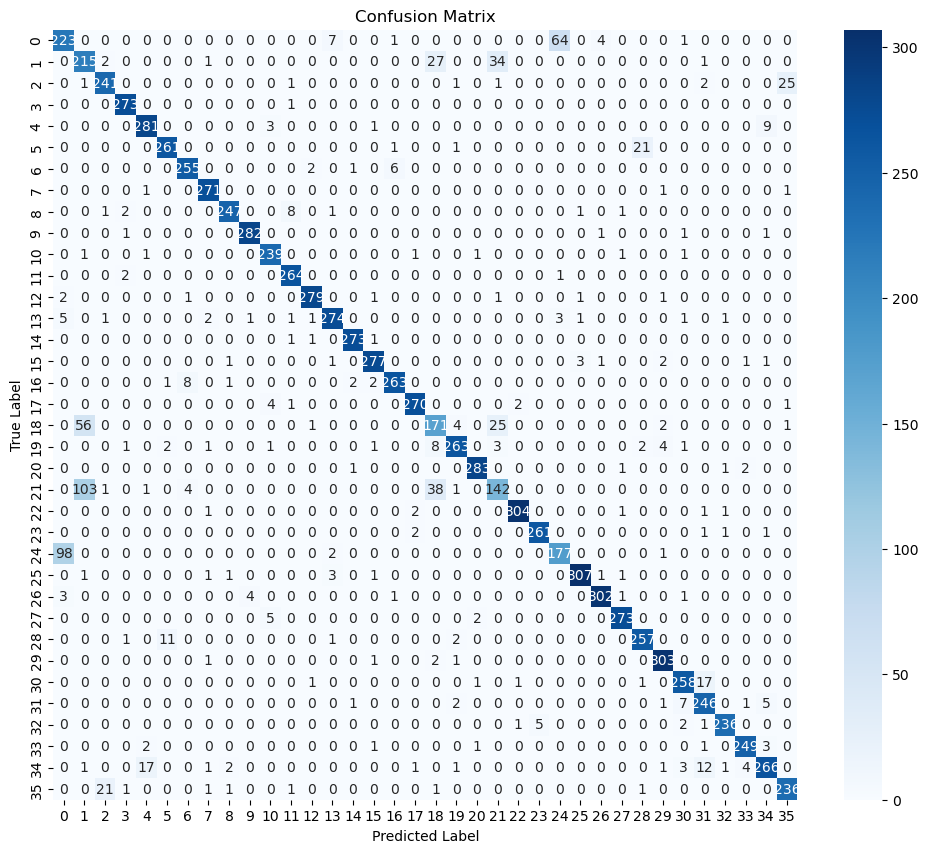

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix_vgg = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_vgg, annot=True, fmt="d", cmap="Blues", xticklabels=range(36), yticklabels=range(36))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


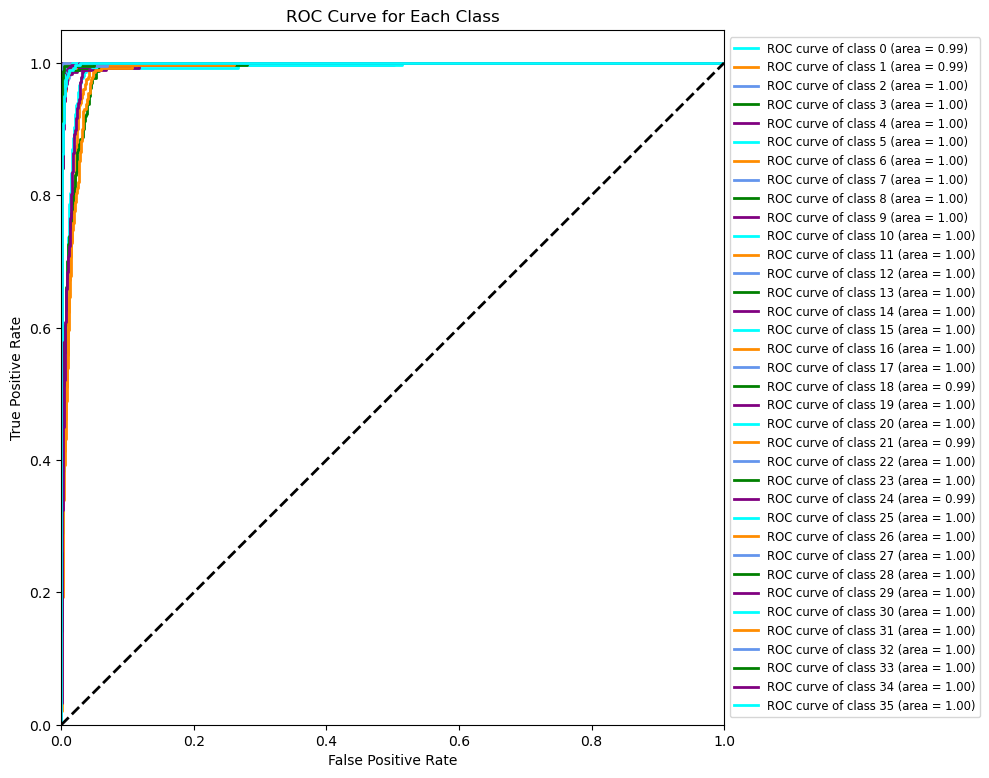

In [27]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
y_test_bin = label_binarize(all_labels_vgg, classes=range(36))
n_classes = y_test_bin.shape[1]

model_vgg.eval()
all_probs = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model_vgg(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())

all_probs = np.array(all_probs)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize='small')
plt.tight_layout()
plt.show()


In [28]:

model_save_path = "model_vgg_with_learning_rate_scheduler.pth"

torch.save(model_vgg.state_dict(), model_save_path)
print(f"Model with Batch Normalization saved to {model_save_path}")


Model with Batch Normalization saved to model_vgg_with_learning_rate_scheduler.pth
